In [124]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import math
import matplotlib.pyplot as plt
import missingno
import scipy.stats as st
import scikitplot as skplt
import warnings
import statsmodels.api as sm

from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

#classifiers
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

%matplotlib inline
warnings.filterwarnings('ignore')

In [42]:
#Load and Preview
df = pd.read_csv('adult.csv')
display(df.shape)
display(df.head())
display(df.tail())
display(df.info())

(32561, 15)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

# **EXPLORATORY ANALYSIS**

In [43]:
for col in df.columns:
    display(df[col].value_counts())

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

123011    13
203488    13
164190    13
126675    12
121124    12
          ..
36376      1
78567      1
180407     1
210869     1
125489     1
Name: fnlwgt, Length: 21648, dtype: int64

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education.num, dtype: int64

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

Male      21790
Female    10771
Name: sex, dtype: int64

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital.gain, Length: 119, dtype: int64

0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital.loss, Length: 92, dtype: int64

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours.per.week, Length: 94, dtype: int64

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

<=50K    24720
>50K      7841
Name: income, dtype: int64

(array([  0.,  25.,  50.,  75., 100., 125.]),
 <a list of 6 Text xticklabel objects>)

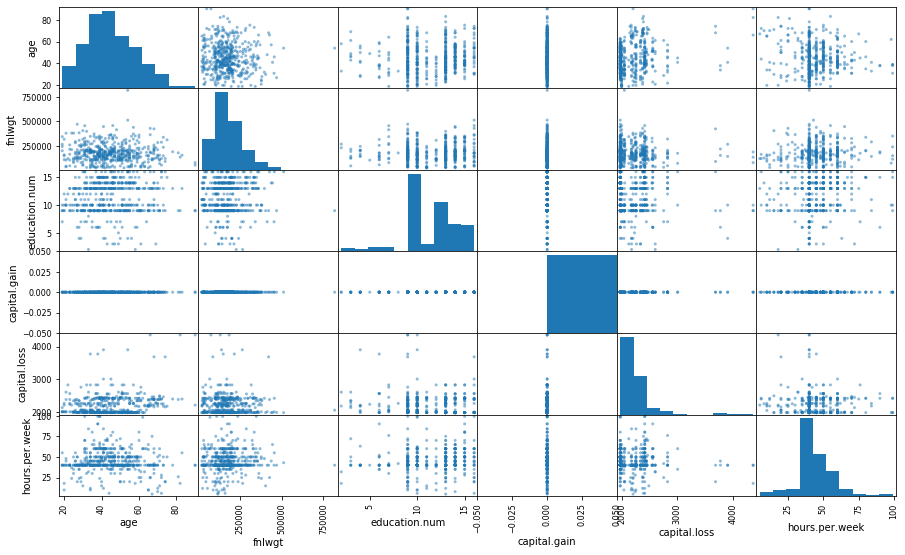

In [44]:
pd.plotting.scatter_matrix(df.head(500), figsize = (15,9), diagonal = 'hist' )
plt.xticks(rotation = 90)

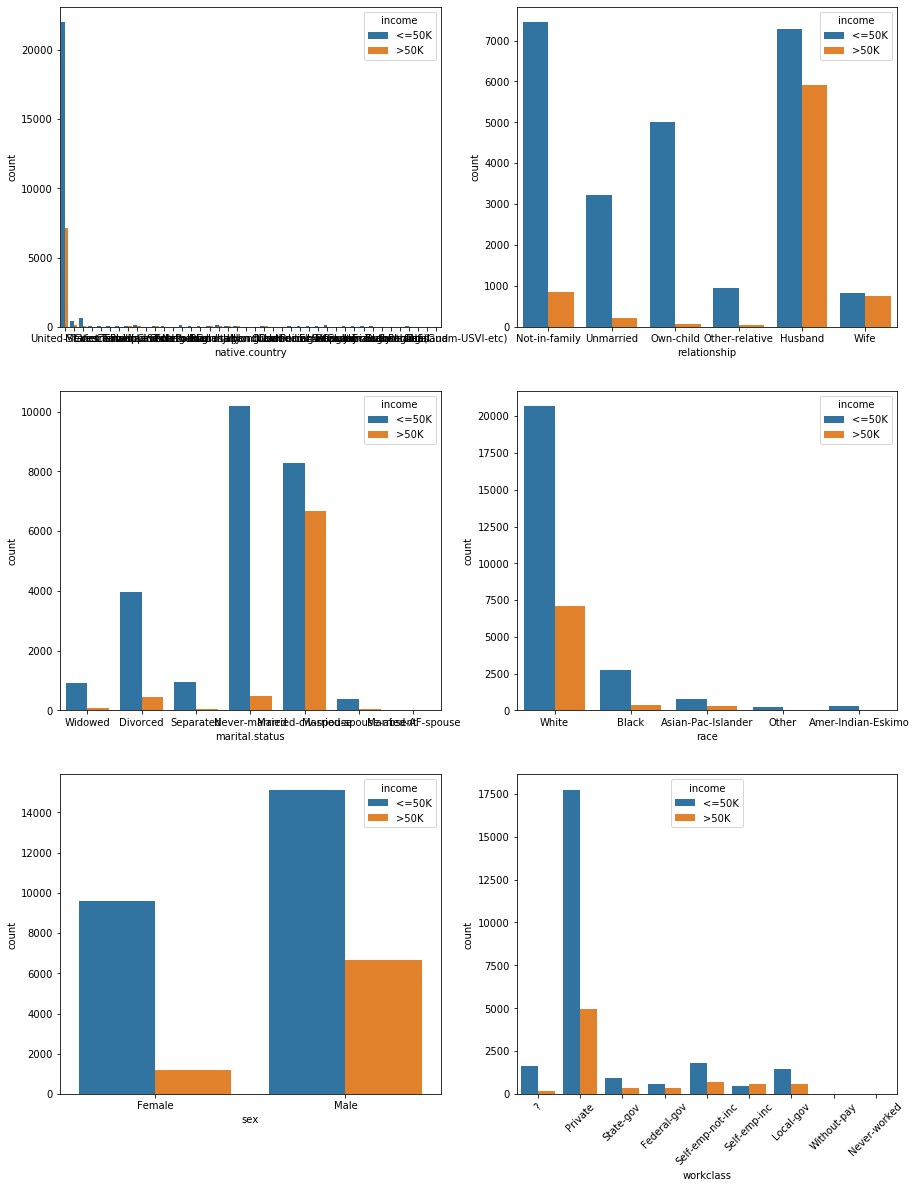

In [45]:
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2,figsize=(15,20))
plt.xticks(rotation=45)
sns.countplot(df['workclass'],hue=df['income'],ax=f)
sns.countplot(df['relationship'],hue=df['income'],ax=b)
sns.countplot(df['marital.status'],hue=df['income'],ax=c)
sns.countplot(df['race'],hue=df['income'],ax=d)
sns.countplot(df['sex'],hue=df['income'],ax=e)
sns.countplot(df['native.country'],hue=df['income'],ax=a)

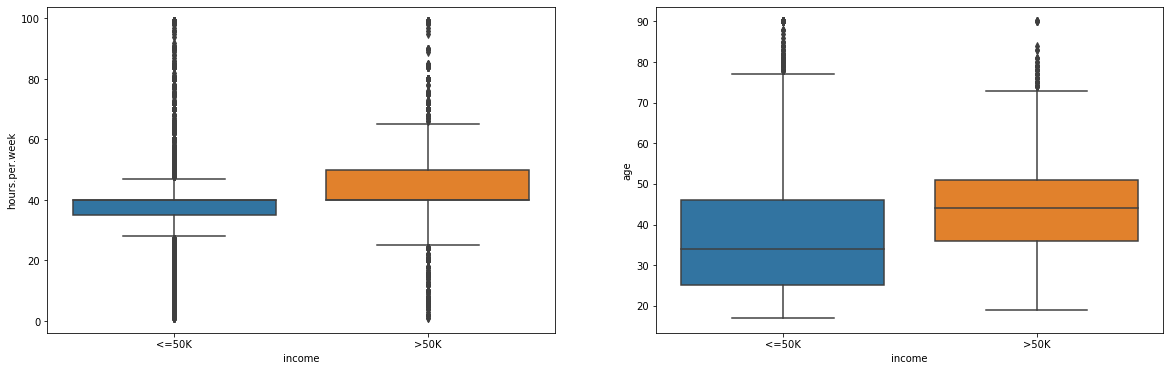

In [46]:
fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.boxplot(y='hours.per.week',x='income',data=df,ax=a)
sns.boxplot(y='age',x='income',data=df,ax=b)

In [47]:
#manipulating data to see it through different perspectives

#df.sort_values(['age','fnlwgt'], ascending = False).head(20)
#df.groupby(df.age).count().plot(kind = 'bar')
#df.groupby('age')['fnlwgt'].mean().sort_values(ascending = False).head(10)
#pd.crosstab(df.age, df.fnlwgt).apply(lambda x: x/x.sum(), axis=1)
#df['young_male'] = ((df.fnlwgt == '19302') & (df.age < 30)).map({True: 'young male', False: 'other'})
#display(df['young_male'])

# **DATA CLEANING**
- Duplicates
- Non-sense values or errors
- Missing values
- Scaling
- Data type conversions
- Randomize data 
- Class imbalances 
- Outliers
- Data Split

### **Nonsense values**
Negative Values, etc

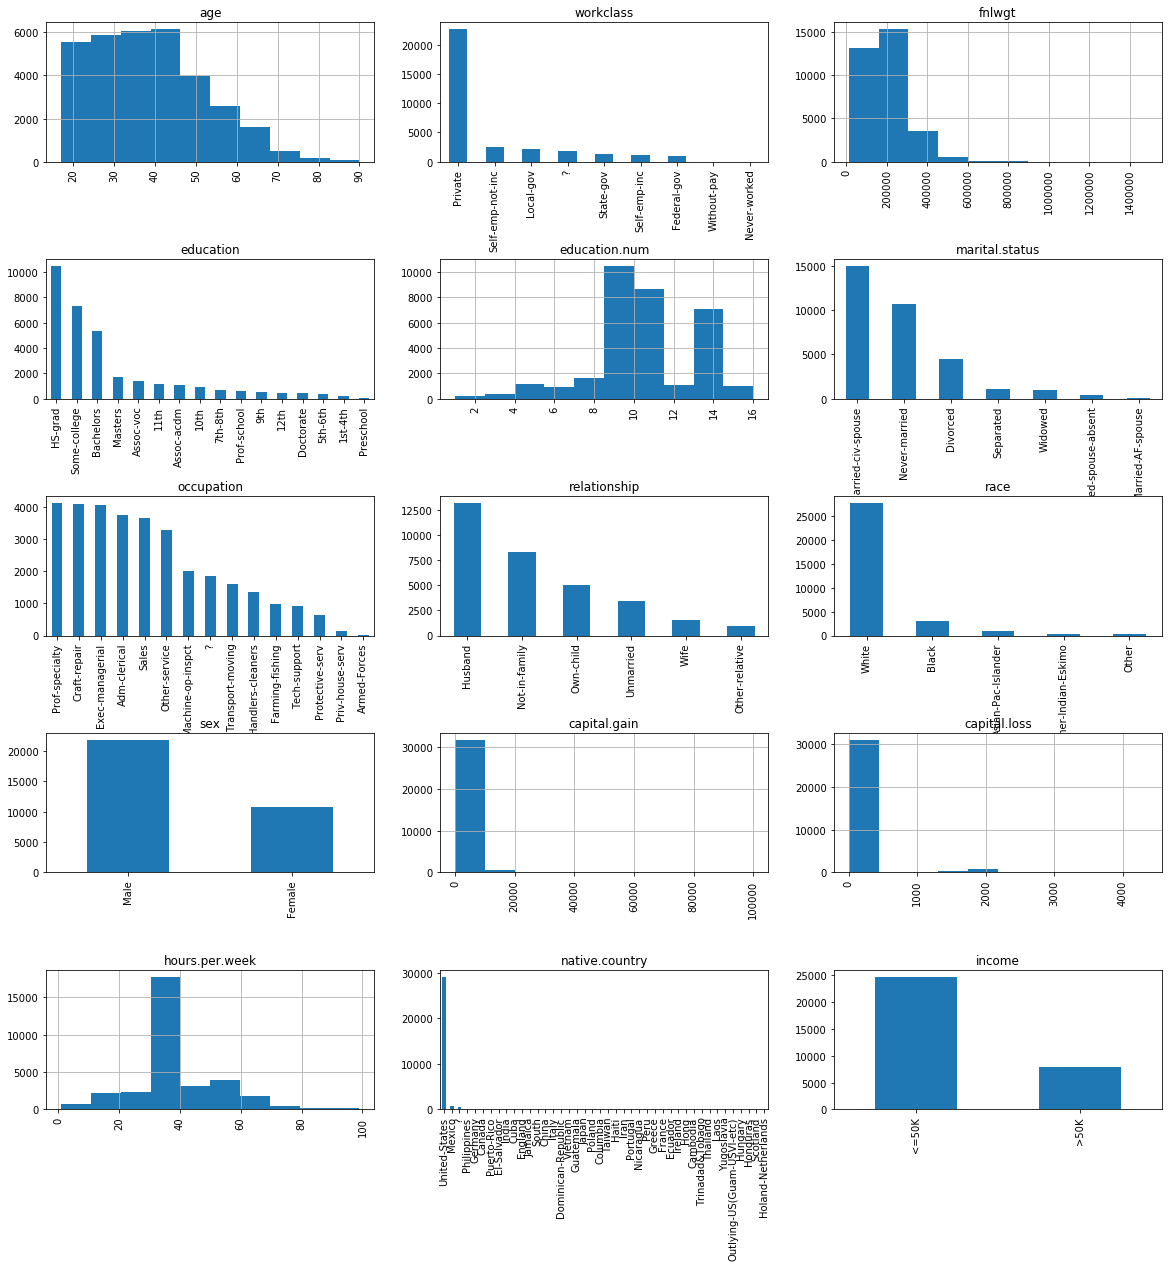

In [48]:
fig = plt.figure(figsize = (20,20))
cols = 3
rows = math.ceil(float(df.shape[1] / cols))
for i, column in enumerate(list(df.columns)):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind = 'bar', axes = ax)
    else:
        df[column].hist(axes = ax)
        plt.xticks(rotation = 'vertical')
plt.subplots_adjust(hspace = 0.7, wspace = 0.2)
plt.show()

In [49]:
pd.set_option('display.max_columns', 100)
for col in df:
    print(col)
    print (df[col].unique())
    print('\n')


age
[90 82 66 54 41 34 38 74 68 45 52 32 51 46 57 22 37 29 61 21 33 49 23 59
 60 63 53 44 43 71 48 73 67 40 50 42 39 55 47 31 58 62 36 72 78 83 26 70
 27 35 81 65 25 28 56 69 20 30 24 64 75 19 77 80 18 17 76 79 88 84 85 86
 87]


workclass
['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']


fnlwgt
[ 77053 132870 186061 ...  34066  84661 257302]


education
['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']


education.num
[ 9 10  4  6 16 15 13 14  7 12 11  2  3  8  5  1]


marital.status
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']


occupation
['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 

In [50]:
display(df.describe(include = 'all')) #it helps to understand non-sense values

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [51]:
#CHECK FOR NEGATIVE VALUES BY COLORING THEM
def color_negative_red(val):
    color = 'red' if val <= 0 else 'black'
    return 'color: %s' % color

test = df[['age','capital.gain', 'capital.loss', 'education.num', 'fnlwgt']]
colored = test.head().style.applymap(color_negative_red)

display(colored)

,age,capital.gain,capital.loss,education.num,fnlwgt
0,90,0,4356,9,77053
1,82,0,4356,9,132870
2,66,0,4356,10,186061
3,54,0,3900,4,140359
4,41,0,3900,10,264663


### **Missing Values**

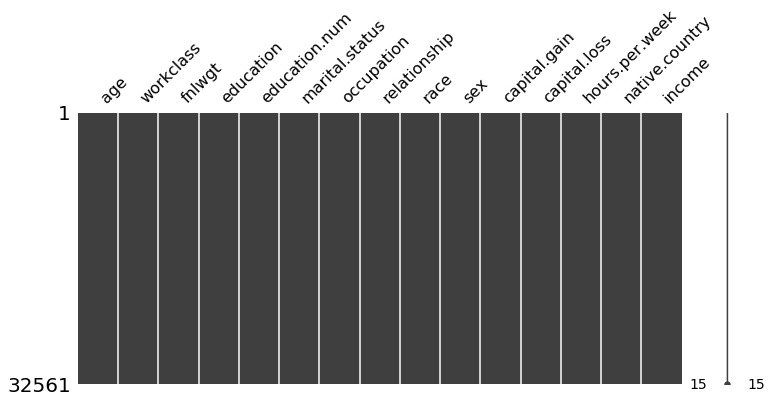

In [52]:
missingno.matrix(df, figsize=(12, 5))

In [53]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [54]:
#convert '?' to NaN
df[df == '?'] = np.nan
display(df.head())

#fill the NaN values with the mode
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
#to just simply drop them, we coud use:
# df.dropna()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


(more examples of operations for replacing values if needed in the future)

In [55]:
"""
#Replace specific values if needed
Replace symbol in whole column
df['age'] = df['age'].str.replace('–', '**', regex = True)


#DROP multiple columns
df.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)


#Find text with regex and replace with nothing
 df = df.replace({
     'age':'[A-Za-z]', 
     'fnlwgt': '[A-Za-z]',
 },'',regex = True)


#Example of applying a formula to entire column

 def euro(cell):
     cell = cell.strip('€')
     return cell
 df.Wage = df.Wage.apply(euro)

#Insert value in cell depending on values from other cells
 def impute_age(cols):
     age = cols[0]
     Pclass = cols[1]
     if pd.isnull(Age):
         if Pclass == 1:
             return 37
         else:
             return 24
     else:
         return Age
         
#CHANGING DATA TYPES
#changing values to float
df[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')
df.column.astype(float)
df.dtypes
"""

"\n#Replace specific values if needed\nReplace symbol in whole column\ndf['age'] = df['age'].str.replace('–', '**', regex = True)\n\n\n#DROP multiple columns\ndf.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)\n\n\n#Find text with regex and replace with nothing\n df = df.replace({\n     'age':'[A-Za-z]', \n     'fnlwgt': '[A-Za-z]',\n },'',regex = True)\n\n\n#Example of applying a formula to entire column\n\n def euro(cell):\n     cell = cell.strip('€')\n     return cell\n df.Wage = df.Wage.apply(euro)\n\n#Insert value in cell depending on values from other cells\n def impute_age(cols):\n     age = cols[0]\n     Pclass = cols[1]\n     if pd.isnull(Age):\n         if Pclass == 1:\n             return 37\n         else:\n             return 24\n     else:\n         return Age\n         \n#CHANGING DATA TYPES\n#changing values to float\ndf[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')\ndf.column.astype(float)\ndf.dtypes\n"

### ** Duplicates **
We can confidently remove duplicates now, because when we'll do the oversampling we we'll use the Smote method that won't generate more duplicates (in contrast to RandomOverSampling). Also, by doing this before the oversampling, we are guaranteeing that we'll have exactly 50%-50% of y-labels balance later.

In [56]:
print(df.duplicated().sum()) #check if there are duplicates
df.drop_duplicates(keep = 'first', inplace = True) #get rid of them

24


### ** Label Encoding **

In [57]:
categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
numerical = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

In [58]:
#using labelencoder
le = LabelEncoder()
for feature in categorical:
        df[feature] = le.fit_transform(df[feature])

### ** Finding Outliers **

We can detect outliers in 3 ways:

- Standard Deviation
- Percentiles (Tukey method)
- Isolation Forest or LocalOutlierFactor (more appropriate for Anomaly/Fraud Detection Problems)

Then, we can handle them by:
 - Remove them
 - Change them to max/min limit
 
The definition of outlier is quite dubious, but we can defined them as those values that surpasse the limit of 1.5 * IQR.
In this case, either the standard deviation method or Tukey method are valid options. We just need to try and see which gives better results (if it produces better results at all).

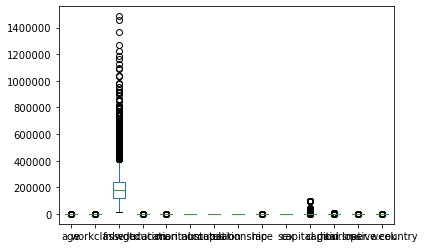

In [59]:
#See outliers through boxplots
df.plot(kind = 'box', sharex = False, sharey = False)
plt.show()

In [60]:
# Tukey Method

n = 2 #In this case, we considered outliers as rows that have at least two outlied numerical values. The optimal value for this parameter can be later determined though the cross-validation
indexes = []

for col in df.columns[0:14]:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1
    
    limit = 1.5 * IQR

    list_outliers = df[(df[col] < Q1 - limit) | (df[col] > Q3 + limit )].index # Determine a list of indices of outliers for feature col
    
    indexes.extend(list_outliers) # append the found outlier indices for col to the list of outlier indices 

indexes = Counter(indexes)        
multiple_outliers = list( k for k, v in indexes.items() if v > n )

df.drop(multiple_outliers, axis = 0)

df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
print(str(len(multiple_outliers)) + " outliers were eliminated")

2499 outliers were eliminated


In [61]:
"""
#Setting the min/max to outliers using standard deviation
for col in df.columns[0:14]:
    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation
    upper_lim = df[col].mean () + df[col].std () * factor
    lower_lim = df[col].mean () - df[col].std () * factor

    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
"""

'\n#Setting the min/max to outliers using standard deviation\nfor col in df.columns[0:14]:\n    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation\n    upper_lim = df[col].mean () + df[col].std () * factor\n    lower_lim = df[col].mean () - df[col].std () * factor\n\n    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]\n'

### ** Dealing with imbalanced data **

income
<=50K    22841
>50K      7197
dtype: int64

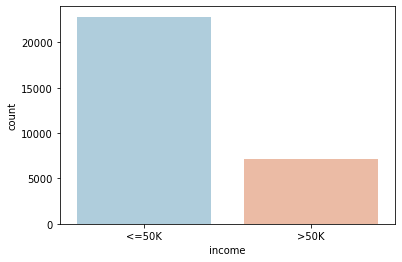

In [62]:
#Check if there are labels imbalance
sns.countplot(x=df['income'],palette='RdBu_r')
df.groupby('income').size()

In [63]:
df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})

Y = df['income']
X = df.drop('income',axis=1)
df[categorical].isnull().sum()

workclass         0
education         0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
native.country    0
dtype: int64

** oversampling the data **

In [64]:
# Oversampling using smote 
smk = SMOTETomek(random_state = 42)
X, Y = smk.fit_sample(X, Y)

"""
# RANDOM Oversample #####
os = RandomOverSampler() #ratio of one feature and another is 50% and 50% respectively
X, Y = os.fit_sample(X, Y)
"""

'\n# RANDOM Oversample #####\nos = RandomOverSampler() #ratio of one feature and another is 50% and 50% respectively\nX, Y = os.fit_sample(X, Y)\n'

In [65]:
#If dowsample was needed...

"""
# RANDOM Undersample #####
os = RandomUnderSampler() #ratio of one feature and another is 50% and 50% respectively
X, Y = os.fit_sample(X, Y)
"""

"""
#Using nearmiss
nm = NearMiss()
X, Y = nm.fit_sample(X, Y)
"""

'\n#Using nearmiss\nnm = NearMiss()\nX, Y = nm.fit_sample(X, Y)\n'

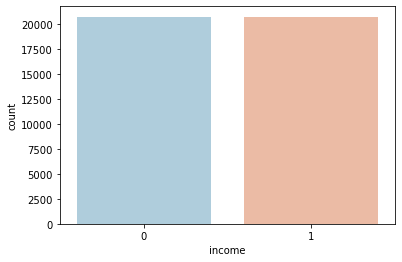

In [66]:
#making sure that everything is good now
df = pd.concat([X, Y], axis=1)
sns.countplot(x=Y,palette='RdBu_r')

### ** DUPLICATES **

In [67]:
Y = df['income']
X = df.drop('income',axis=1)

# **Feature Engineering**
- Feature Creation (Modidy existing features) -> Scaling, normalize, standarize, logarithim, ...
- Feature Transformation (Add useful features) -> Modify to new, Combine features, Cluster some feature, ...
- Feature Selection/Reduction (Remove useless features) -> See feat importance, correlations, Dimensionality reduction,

# **Feature Selection**

As we only have 14 features, we are not pressured to make a feature selection/reduction in order to increase drastically the computing time of the algorithms. So, for now, we are going to investigate if there are features extremely correlated to each other. After tuning and choosing the best model, we are revisiting feature selection methods just in case we face overfitting or to see if we could achieve the same results with the chosen model but with fewer features.

### ** Correlation **

In [68]:
#Simple regression line of various variables in relation to  one other
#sns.pairplot(X, x_vars = ['capital.loss', 'hours.per.week', 'education.num'], y_vars = 'age', size = 7, aspect = 0.7, kind = 'reg')

In [69]:
# Correlation between variables each other. It may take a while, not advised if there are plenty of features
#sns.pairplot(data = X)

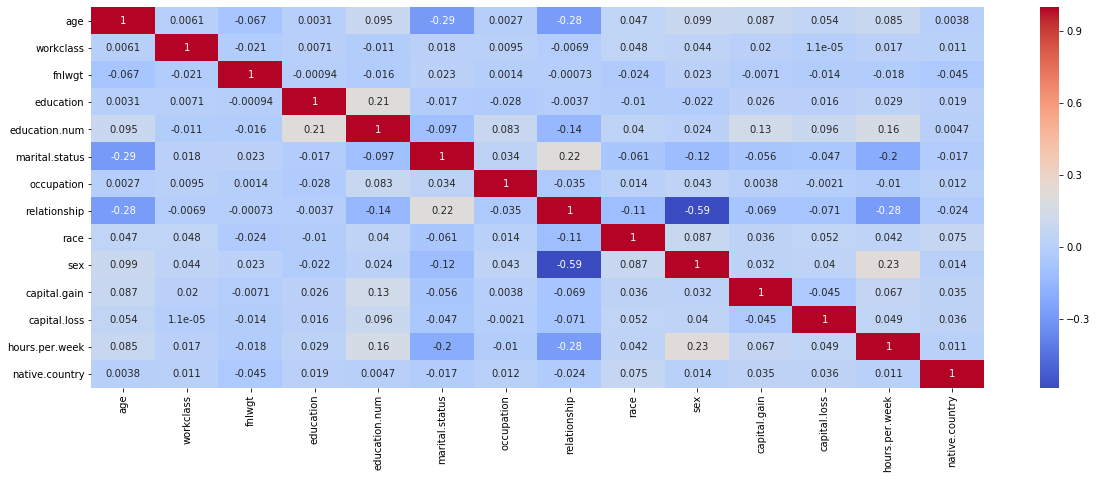

In [107]:
plt.subplots(figsize=(20,7))
sns.heatmap(X.corr(method = 'pearson'),annot=True,cmap='coolwarm') # the method can also be 'spearman' or kendall'

#to see the correlation between just two variables
#df['age'].corr(df['capital.gain']) 

** Generally all of the features are not highly correlated (no correlations above abs(0.5)). The strongest correlations here is "sex"vs"relationship". Down bellow are the procedures to drop the highest correlated features, even though it's not needed in this case or it might even result in worse results.

### ** Base Line Model **

In [1095]:
l=pd.DataFrame(Y)
l['baseline'] = 0
k = pd.DataFrame(confusion_matrix(Y,l['baseline']))
print(k)
print("Accuracy: " + str(accuracy_score(Y, l['baseline'])))

       0  1
0  20756  0
1  20756  0
Accuracy: 0.5


### ** One Hot Encoding **

In [1096]:
encoded_feat = pd.DataFrame(OneHotEncoder(categories="auto").fit_transform(df[categorical]).toarray())

#concatenate without adding null values -.-''
l1=encoded_feat.values.tolist()
l2=df[numerical].values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])

X=pd.DataFrame(l1,columns=encoded_feat.columns.tolist()+df[numerical].columns.tolist())


### ** Scaling **

In [1097]:
col_names = X.columns

features = X[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features

In [ ]:
#Another method of scaling using minimax
##https://www.andreagrandi.it/2018/04/14/machine-learning-pima-indians-diabetes/

from sklearn.preprocessing import MinMaxScaler as Scaler

scaler = Scaler()
scaler.fit(train_set)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### ** Split Data **

shuffle before split

In [1098]:
l1=X.values.tolist()
l2=pd.DataFrame(Y).values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])

new_df=pd.DataFrame(l1,columns=X.columns.tolist()+pd.DataFrame(Y).columns.tolist())

new_df = shuffle(new_df, random_state=42)

In [1099]:
train,test = train_test_split(new_df,test_size=0.2)

y_train = train['income']
X_train = train.drop('income',axis=1)
y_test = test['income']
X_test = test.drop('income',axis=1)


### **Logistic Regression (all features)**

In [1100]:
clf = LogisticRegression()

model = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

y_score = model.decision_function(X_test)


k = pd.DataFrame(confusion_matrix(y_test,y_pred))
print(k)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,average='binary')

print('Precision: {} / Recall: {}'.format(round(precision, 3),
                                                        round(recall, 3)))

      0     1
0  3573   573
1   558  3599
Accuracy: 0.863784174394797
Precision: 0.863 / Recall: 0.866


** ROC CURVE AND AUC **

0.9432317129140475


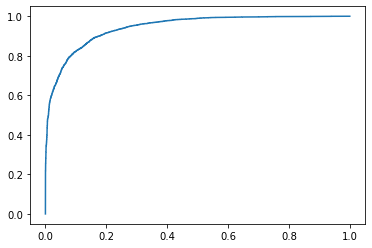

In [1101]:
fpr,tpr,the = roc_curve(y_test,y_score)
roc_auc_score(y_test,y_pred)
plt.plot(fpr,tpr,)
print(roc_auc_score(test['income'],y_score))

### ** Decision Tree **

In [1102]:
clf = DecisionTreeClassifier(max_features=14,min_samples_leaf=100,random_state=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

      0     1
0  3514   632
1   644  3513
Accuracy: 0.8463206070095146
Precision: 0.848 / Recall: 0.845


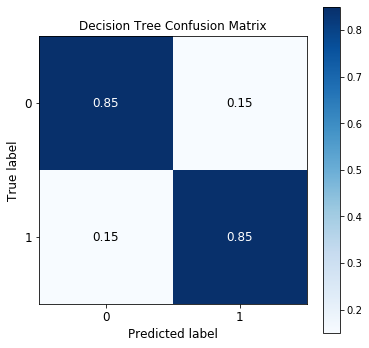

In [1103]:
k = pd.DataFrame(confusion_matrix(y_test,y_pred))
print(k)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,average='binary')

print('Precision: {} / Recall: {}'.format(round(precision, 3),
                                                        round(recall, 3)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, title="{} Confusion Matrix".format("Decision Tree"),
            normalize=True,figsize=(6,6),text_fontsize='large')
plt.show()


### ** Technique to prun decision trees **

In [ ]:
# PRUNNING DECISION TREES
#https://stackoverflow.com/questions/49428469/pruning-decision-trees
'''Directly restricting the lowest value (number of occurences of a particular class) of a leaf
cannot be done with min_impurity_decrease or any other built-in stopping criteria.
I think the only way you can accomplish this without changing the source code 
of scikit-learn is to post-prune your tree. 
To accomplish this, you can just traverse the tree 
and remove all children of the nodes with minimum class count less than 5 
(or any other condition you can think of). I will continue your example:'''

from sklearn.tree._tree import TREE_LEAF

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

print(sum(dt.tree_.children_left < 0))
# start pruning from the root
prune_index(dt.tree_, 0, 5)
sum(dt.tree_.children_left < 0)

### ** XGBoost **

In [1104]:
clf = XGBClassifier()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [1105]:
k = pd.DataFrame(confusion_matrix(y_test,y_pred))
print(k)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,average='binary')

print('Precision: {} / Recall: {}'.format(round(precision, 3),
                                                        round(recall, 3)))

      0     1
0  3672   474
1   495  3662
Accuracy: 0.8832951945080092
Precision: 0.885 / Recall: 0.881


### ** CATboost **

In [1106]:
clf = CatBoostClassifier(learning_rate=0.04)

model = clf.fit(X_train,y_train)


0:	learn: 0.6555438	total: 66.7ms	remaining: 1m 6s
1:	learn: 0.6190734	total: 117ms	remaining: 58.2s
2:	learn: 0.5872023	total: 189ms	remaining: 1m 2s
3:	learn: 0.5606131	total: 216ms	remaining: 53.7s
4:	learn: 0.5373892	total: 275ms	remaining: 54.7s
5:	learn: 0.5166281	total: 334ms	remaining: 55.4s
6:	learn: 0.4976542	total: 371ms	remaining: 52.7s
7:	learn: 0.4811988	total: 394ms	remaining: 48.8s
8:	learn: 0.4660132	total: 433ms	remaining: 47.7s
9:	learn: 0.4528181	total: 466ms	remaining: 46.1s
10:	learn: 0.4409875	total: 496ms	remaining: 44.6s
11:	learn: 0.4324209	total: 519ms	remaining: 42.7s
12:	learn: 0.4207363	total: 555ms	remaining: 42.1s
13:	learn: 0.4123217	total: 582ms	remaining: 41s
14:	learn: 0.4055516	total: 634ms	remaining: 41.6s
15:	learn: 0.3970849	total: 667ms	remaining: 41s
16:	learn: 0.3907618	total: 689ms	remaining: 39.9s
17:	learn: 0.3835052	total: 759ms	remaining: 41.4s
18:	learn: 0.3783530	total: 815ms	remaining: 42.1s
19:	learn: 0.3729145	total: 848ms	remaining:

In [1107]:
y_pred = clf.predict(X_test)

k = pd.DataFrame(confusion_matrix(y_test,y_pred))
print(k)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,average='binary')

print('Precision: {} / Recall: {}'.format(round(precision, 3),
                                                        round(recall, 3)))

      0     1
0  3756   390
1   429  3728
Accuracy: 0.9013609538720945
Precision: 0.905 / Recall: 0.897


### Finding the best hyperparameters for the models under analysis
Just tuning the crutial parameters, not all of them.
I intercalate between randomizedSearch and GridSearch to diversify

In [1108]:
models = []
models.append(('NB', GaussianNB()))
tuning_num_folds = 5
jobs=4
num_random_state=10
scoring_criteria='accuracy'

** Tuning Logistic Regression **

In [1109]:
C_vals = [0.0001, 0.001, 0.01, 0.1,0.13,0.2, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 4.0,4.5,5.0,5.1,5.5,6.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']
param = {'penalty': penalties, 'C': C_vals}

grid = GridSearchCV(LogisticRegression(), param,verbose=False, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('LR', LogisticRegression(penalty=grid.best_params_['penalty'], C=grid.best_params_['C'])))

KeyboardInterrupt: 

** CatBoostClassifier Tuning**

In [ ]:
param = {'iterations': [100, 150], 'learning_rate': [0.3, 0.4, 0.5]}

grid = GridSearchCV(CatBoostClassifier(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('CAT', CatBoostClassifier(iterations=grid.best_params_['iterations'], learning_rate=grid.best_params_['learning_rate'])))

** Random Forest Tuning **

In [ ]:
params ={
             'max_depth': st.randint(3, 11),
            'n_estimators': [50,100,150,200,250],
             'max_features':["sqrt", "log2"],
             'max_leaf_nodes':st.randint(6, 10)
            }

skf = StratifiedKFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

models.append(('RF', RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'], max_features=random_search.best_params_['max_features'], max_leaf_nodes=random_search.best_params_['max_leaf_nodes'], max_depth=random_search.best_params_['max_depth'])))


** XGBClassifier Tuning **

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

skf = StratifiedKFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(XGBClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

models.append(('XGB', XGBClassifier(colsample_bytree=random_search.best_params_['colsample_bytree'], gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], min_child_weight=random_search.best_params_['min_child_weight'], subsample=random_search.best_params_['subsample'])))


** MLPClassifier tuning **


In [ ]:
param ={'max_iter': np.logspace(1, 5, 10).astype("int32"),
             'hidden_layer_sizes': np.logspace(2, 3, 4).astype("int32"),
             'activation':['identity', 'logistic', 'tanh', 'relu'],
             'learning_rate': ['adaptive'],
             'early_stopping': [True],
             'alpha': np.logspace(2, 3, 4).astype("int32")
            }

grid = GridSearchCV(MLPClassifier(), param,verbose=False, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('MLP', MLPClassifier(max_iter=grid.best_params_['max_iter'], hidden_layer_sizes=grid.best_params_['hidden_layer_sizes'], activation=grid.best_params_['activation'], early_stopping=grid.best_params_['early_stopping'], learning_rate=grid.best_params_['learning_rate'], alpha=grid.best_params_['alpha'])))

** KNeighborsClassifier tuning **

In [ ]:
params ={'n_neighbors': st.randint(1,40),
            'weights':['uniform','distance']
            }

skf = StratifiedKFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

models.append(('KNN', KNeighborsClassifier(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'])))


** Linear Discriminant tuning **

In [ ]:
param={'solver': ['svd', 'lsqr', 'eigen']}

grid = GridSearchCV(LinearDiscriminantAnalysis(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('LDA', LinearDiscriminantAnalysis(solver=grid.best_params_['solver'])))

** DecisionTreeClassifier tuning **

In [ ]:
param = {'min_samples_split': [4,7,10,12]}

grid = GridSearchCV(DecisionTreeClassifier(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('DTC', DecisionTreeClassifier(min_samples_split=grid.best_params_['min_samples_split'])))

** SVC tuning **

In [ ]:
param={'C':[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5],
      'kernel': ["linear","rbf"]
      }

grid = GridSearchCV(SVC(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('SVC', SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])))


** SGDClassifier tuning **

In [ ]:
param ={'loss':["hinge","log","modified_huber","epsilon_insensitive","squared_epsilon_insensitive"]}

grid = GridSearchCV(SGDClassifier(), param,verbose=False, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

models.append(('SGD', SGDClassifier(loss=grid.best_params_['loss'])))

** GradientBoostingClassifier tuning **

In [ ]:
param_grid ={'n_estimators': st.randint(100, 800),
            'loss': ['deviance', 'exponential'],
            'learning_rate': [0.1, 0.01,0.05,0.001],
            'max_depth': np.arange(2, 12, 1)}


random_search = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

models.append(('GraBoost', GradientBoostingClassifier(n_estimators=random_search.best_params_['n_estimators'], loss=random_search.best_params_['loss'], max_depth=random_search.best_params_['max_depth'], learning_rate=random_search.best_params_['learning_rate'])))

** AdaBoostClassifier tuning **

In [ ]:
params ={'n_estimators':st.randint(100, 800),
        'learning_rate':np.arange(.1, 4, .5)}


random_search = RandomizedSearchCV(AdaBoostClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

models.append(('Ada', AdaBoostClassifier(n_estimators=random_search.best_params_['n_estimators'], learning_rate=random_search.best_params_['learning_rate'])))

# Find the best Model

In [ ]:
validation_size = 0.20
seed = 7
num_folds = 10
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,
    test_size=validation_size,random_state=seed)


# evalutate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Ensemble, voting, bagging, boosting, etc

Statistical tests, Comparing, Ranking, etc

In [ ]:
fig = plt.figure()
fig.suptitle('Algorith Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Checking overfitting/underfiiting. Another Interation on Feature Selection/Reduction

Filter Method - easiest but not the best way

In [ ]:
"""
#Filter Method - easiest but not the best way
print(X[["sex","relationship"]].corr())

X = X.drop('relationship',axis=1)
"""

### BACKWARD ELIMINATION (wrapper method 1)

- 1) We select a significance level (SL) to stay in the model
- 2) Fit the full model with all possible predictors
- 3) Loop (while p-value < SL)
    - 4) Consider the predictor with highest p-value. 
    - 5) Remove the predictor
    - 6) Fit model without this variable
    
So basically we are feeding all the possible features to the model and then proceed to iteratively remove 
the worst performing features one by one. The metric to evaluate feature performance is pvalue above 0.05 (to keep the feature).


In [ ]:
pmax = 1
SL = 0.05 # the smaller the SL, the more features will be removed

while (len(X.columns) > 0):
    
    p_values = []
    
    Xtemp = X[X.columns]
    Xtemp = sm.add_constant(Xtemp)
    model = sm.OLS(Y,Xtemp).fit()
    
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    p_max = max(p)
    feature_pmax = p.idxmax()
    
    if(p_max > SL):
        cols.remove(feature_pmax)
    else:
        break

print('Features Selected: ', cols)

X = X[cols]

"""
#If we just want to perform OLS regression to find out interesting stats:
X1 = sm.add_constant(X)
model = sm.OLS(Y, X1).fit()
display(model.summary())
print(model.pvalues)
"""

So, in our case, backward elimination is telling us that we should remain with all the features. No need to drop any of them :)

### FORWARD SELECTION (wrapper method 2)

Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

In [ ]:
sfs1 = sfs(LinearRegression(), k_features=len(X.columns) , forward=True , scoring='r2')
sfs1 = sfs1.fit(X,Y)
fig = plot_sfs(sfs1.get_metric_dict())
plt.grid(True)
plt.show()

print(sfs1.k_feature_names_)

"""
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

sfs1 = sfs(model_1 , k_features=9 , forward=True , scoring='r2')
sfs1 = sfs1.fit(X_train,y_train)
sfs1.k_feature_names_

lr=LinearRegression().fit(X_train,y_train)
y_pred_fs=lr.predict(X_test)
r2_score(y_test,y_pred_fs)
"""

### RECURSIVE FEATURE ELIMINATION (wrapper method 3)

It is a greedy optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. We need to find the optimum number of features, 
for which the accuracy is the highest. It then ranks the features based on the order of their elimination.

In [ ]:
nof_list=np.arange(1,len(df.columns)+1)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
#Now that we now the perfect number of features, we feed them to a RFE and get the final set of features given by RFE:'''
cols = list(X.columns)
model = LogisticRegression()

rfe = RFE(model, nof)             

X_rfe = rfe.fit_transform(X,Y)  

model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

X = X[selected_features_rfe]

print(rfe.support_)
print(rfe.ranking_)

FEATURE SELECTION - EMBEDDED METHOD

In [ ]:
'''We iterate over the model training process and carefully 
extract those features which contribute the most 
to the training for a particular iteration, 
penalizing a feature given a threshold.
Here we will do feature selection using Lasso regularization. 
If the feature is irrelevant, lasso penalizes its coefficient making it 0. 
Features with coefficient = 0 are removed.'''

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model");plt.show()

#Here Lasso model has taken all the features except NOX, CHAS and INDUS.

Example of SelectKBest (chi2)

In [ ]:
#EXAMPLE OF USING SICKIT LEARN TO SELECT THE TWO BEST FEATURES
#https://github.com/knathanieltucker/bit-of-data-science-and-scikit-learn/blob/master/notebooks/FeatureSelection.ipynb
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)

fit = bestfeatures.fit(X,np.ravel(y))
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

** Example of ExtRaTreesClassifier() **

In [ ]:
#FEATURE SELECTION USING EXTRA TREES CLASSIFIER
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

** Example of RFECV(RandomForestClassifier()) **

In [ ]:
#RECURSIVE FEATURE ELIMINATION with cross validation (using Random Forest)
'''Assigns weights to features (e.g., the coefficients of a linear model). 
Features whose weights are the smallest are pruned out.'''

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

m = RFECV(RandomForestClassifier(), scoring = 'accuracy')
m.fit(X,y)
m.score(X,y)

Example of SelectFromModel (LinearSVC)

In [ ]:
#FEATURE SELECTION USING SelectFromModel AND SVC

'''features are considered unimportant and removed, 
if the corresponding coef_ or featureimportances values 
are below the provided threshold parameter.
Available heuristics are “mean”, “median” 
and float multiples of these like “0.1*mean”.'''

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

m = SelectFromModel(LinearSVC(C=0.01, penalty='l1', dual=False))
m.fit(X, y)

** Example of SelectFromModel (LassoCV) **

In [ ]:
#FEATURE SELECTION USING SelectFromModel AND LASSO

from sklearn.linear_model import LassoCV

m = SelectFromModel(LassoCV(cv = 5))
m.fit(X,y)
#m.transform(X).shape

PCA

In [ ]:
sklearn_pca = PCA(n_components=len(X.columns))
Y_sklearn = sklearn_pca.fit_transform(X)

cum_sum = sklearn_pca.explained_variance_ratio_.cumsum()

sklearn_pca.explained_variance_ratio_[:10].sum()

cum_sum = cum_sum*100

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(range(len(X.columns)), cum_sum, label='Cumulative _Sum_of_Explained _Varaince', color = 'b',alpha=0.5)

In [ ]:
In this case every feature adds significant variance to the data, so it's not a good idea to make dimensionality reduction

## Save models and ML pipeline

## Load models, to make predictions


FULL DATA CLEANSING AND CLASSIFICATION PIPELINE¶

In [ ]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(0)

# Read data from Titanic dataset.
df = pd.read_csv('https://raw.githubusercontent.com/amueller/'
               'scipy-2017-sklearn/091d371/notebooks/datasets/titanic3.csv')

#We create the preprocessing pipelines for both numeric and categorical data
numeric_features = ['age','fare']

numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Append classifier to preprocessing pipeline
#Now we have a full prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

X = df.drop('survived', axis = 1)
y = df['survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

Format to get predictions from new data

In [ ]:
DIMENSIONALITY REDUCTION - PCA

In [ ]:
#EXAMPLE OF DIM REDUCTION WITH PCA
#We first scale the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
#scaled_data.shape

#Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) #2 is the number of dimension we want
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
#scaled_data.shape

plt.figure(figsize = (8,6))
plt.scatter(x_pca[:,0], x_pca[:,1],c=df['target_col'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

A typical ML implementation for a classification problem

In [ ]:

#https://www.andreagrandi.it/2018/04/14/machine-learning-pima-indians-diabetes/
# Import all the algorithms we want to test
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection

# Prepare an array with all the algorithms
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('LSVC', LinearSVC()))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier()))
models.append(('SVM', SVC(gamma = 'auto')))

#REGRESSION ALGORITHMS
#models.append(('LR', LogisticRegression()))
#models.append(('DTR', DecisionTreeRegressor()))
#models.append(('SGDRegressor', linear_model.SGDRegressor())) 
#models.append(('BayesianRidge', linear_model.BayesianRidge()))
#models.append(('LassoLars', linear_model.LassoLars())) 
#models.append(('ARDRegression', linear_model.ARDRegression())) 
#models.append(('PassiveAggressiveRegressor', linear_model.PassiveAggressiveRegressor())) 
#models.append(('TheilSenRegressor', linear_model.TheilSenRegressor()))
#models.append(('LinearRegression', linear_model.LinearRegression())) 


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
num_folds = 3
scoring = 'accuracy'

# Prepare the configuration to run the test
seed = 7
results = []
names = []
X = train_set_scaled
y = train_set_labels

# Every algorithm is tested and results are
# collected and printed
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=3, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name, cv_results.mean(), cv_results.std())
    print(msg)
    
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#ONCE CHOSEN THE ALGORITHM, WE DO SCALING, PARAM GRID K FOLD AND GRID SEARCH #################
# Build a scaler
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# Build parameter grid
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

# Build the model
model = SVC()
kfold = KFold(n_splits = num_folds, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, y_train)

# Show the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#MODEL IS NOW READY TO BE SAVED AND USED
##############################################################################################

Finding best parameters with GridSearchCV

In [ ]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py

from sklearn.model_selection import GridSearchCV

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(clf, param_grid, cv=10, iid=False)
grid_search.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

In [ ]:
#GRADIENT DESCENT = iterative technique to minimize complex loss function

'''Two ways to combat overfitting:
1. Use more training data. The more you have, the harder it is to overfit
the data by learning too much from any single training example.

2. Use regularization. Add in a penalty in the loss function for building
a model that assigns too much explanatory power to any one feature or
allows too many features to be taken into account.'''

'''Regularization loss: how much we penalize the model 
for having large parameters that heavily weight certain features'''

In [ ]:

#Basic Keras neural network
#Source: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

# load the dataset
dataset = loadtxt(r'D:\Downloads\DATASETS\general\pima_indian_dataset.csv', delimiter=',')

# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X, y, epochs=20, batch_size=40)

# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))